**A Breif Introduction to Generative Adversarial Network (GAN)**

![](https://images.app.goo.gl/Vt9xsqgFvafruVxU6)

Perhaps all of you heard about Deepfake where AI can generate fake speech or images which are hard to difficult to distinguish from the actual one. These systems are built on Generative Adversarial Network (GAN) and currently it's one of the most versatile neural network architecture.

**History of GAN**


In early 1960s, one of the pioneers of AI, Herbert Simon noticed that machine maybe a match of cognitive abilities of humankind , perform routine tasks. To make machine behave more human, researchers has designed an advanced neural architecture for replicating coginitive intelligence. GANs architecture has been introduced by Ian Goodfellow et. al. from University of Montreal in 2014. This model has become so popular that Yann LeCun (Facebook AI research director) addressed it as the most interesting idea in the last ten years in the world of Machine Learning.

[Original GAN paper](https://arxiv.org/abs/1406.2661)

**How GAN actually works**


A generative adversarial network (GAN) is a part of machine learning frameworks that trains a generative model having two sub-networks. One is a generative network, and the other is a discriminative network.

Generative Network: It works like a deconvolution network and tries to create images or speech using random noise .
Discriminative Network: It assesses those data and tries to differentiate between real or fake one as a convolution network.
So, the generative network creates candidates while the discriminative network judges them. Discriminative networks identify the general model-generated samples as real or fake. GAN training works as supervised learning. The generator produces new counterfeit data, and the discriminator learns to identify between natural and artificial data.

Firstly, the generator is equipped with fixed-length random data as input. This data is drawn from predefined latent space. Then the generator is trained by deceiving the discriminator enough. Finally, the discriminator evaluates them and specifies the real and fake data. Initially, the discriminator is trained with a known dataset until it reaches acceptable accuracy. It is a simple classification model. After training has been done, the discriminator is terminated. Independent backpropagation can help to produce better sample data.

![Architecture](https://images.app.goo.gl/WWDmFvCm5XQCgDRXA)

**Implementation**

In this code I'm implementing GAN to a  [Pokeman dataset](https://www.kaggle.com/kvpratama/pokemon-images-dataset). These images along with the fake ones will be fed in batches to the Discriminator.Let's take a look at the steps our GAN will follow-

Here, two neural network will compete with each other . The discriminator will detect the ground truth ( real or fake ) of generated images and return possiblities a number between 0 and 1 . here 0 represent fake and 1 is real .-

**Importing Libaries**

This section imports all the necessary libraries to build the model as well as to plot the necessary results.

In [1]:
import os 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Path = "../input/pokemon-images-dataset/pokemon_jpg"

In this part,python library is called for path handling.

In [3]:
os.listdir(Path)

['pokemon_jpg']

This block mainly involves the preprocessing as well as augmentation of the dataset.In our dataset pokemon images have been used.At first, we have resized the dataset to (64,64).After that, cropping has been applied. Since we are working in pytorch, we need to convert this numpy arrays into tensor. "tt.ToTensor" achieves this task. And then comes the classic preprocessing task called "Normalization". Normalization is performed so that deep learning model can easily do the computation. Finally,horizontal flip is performed over the normalized images. To send the images easily into the network,a dataloader has been created with suitable batch size with shuffling enabled.

In [4]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(Path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats),
    tt.RandomHorizontalFlip(p=0.5)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

This part does the task of plotting.

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [7]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

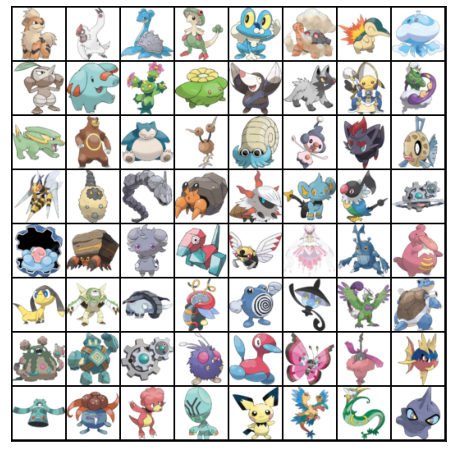

In [8]:
show_batch(train_dl)

This block checks if the cuda is enabled to take advantage of the gpu. Otherwise it will run the code on cpu. This code creates the dataloader for the device as well.

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

This code sends the train dataloader to the device(cuda/cpu). 

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

This is the core of our tutorial. This is block where the model has been built.Since GAN has basically two networks--Discriminator and Generator. This block builds the discriminator network.As we can see from the code basically there are repeated use of three layers which constitue a single block.If we observe the block carefully,first there is a convolution layer which extracts low level details from the image. And then batchnormalization is applied.For activation function,leakyrelu is applied.In the last layer,we have flattened the tensors and passed them through the sigmoid activation layer.

In [12]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
discriminator = to_device(discriminator,device)

We have used a latent size of 128. Here is the generator block which consists of transposed convolutional layer. And then batch normalization is used.For activation function,Relu is used which is different from discriminator network. Finally,at the end of the generator block,tanh activation layer is applied.

In [14]:
latent_size = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()
)

In this block,we have tested the generator block with some random latent tensors.The main goal of this block is to see whether the generator works or not. And the main task of the generator is to produce fake images.

torch.Size([64, 3, 64, 64])


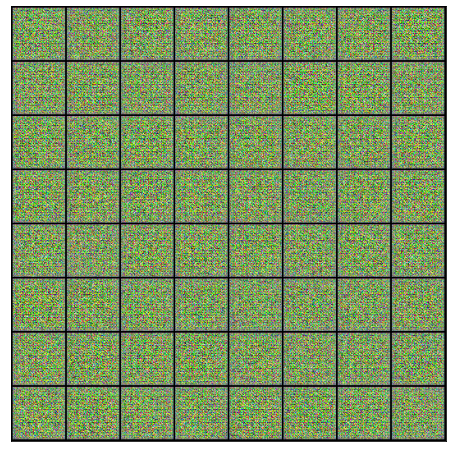

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator,device)

This part is the cream of this tutorial where we wll perform the training of this GAN model.Eventually,we will train the discriminator first.For that,we will first clear the gradient of the discriminator network,which is basically initialize the discriminator network with zero weight. And then real images are passed through this.The main task of the discriminator is to distinguish the real images from the fake ones,generated from the generator network.To be precise, we will try to minimize the loss function of the discriminator net. For the loss function, we have used binary cross-entropy to calculate the loss between real and fake images. Proceeding forward, we observe that fake images are passed through this net to calculate fake loss. In the end,both fake and real loss are summed to calculated the total loss.This loss will be used in the backpropagation phase to update the weight of the discriminator network.And this is done in the last part of this block. Finally this block will output some real scores and fake scores.

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

This block is pretty similar to the block explained above.Here we are training the generator network.The generator network will basically train through the discriminator network. The goal of the generator network is to produce fake images to fool the discriminator. Its like a competition going between generator and discriminator.Through this game, the loss function of both the network will come into an equilibrium point when the generator will learn to produce images which will look perfectly like real ones.Just like the discriminator network,this net will update its weights through loss function.

In [18]:
def train_generator(opt):
    opt.zero_grad()
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds,targets)
    loss.backward()
    opt.step()
    return loss.item()
    

In [19]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In this block, we will save the images generated from the generator network.In the end, we will plot them to compare with the real images.

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


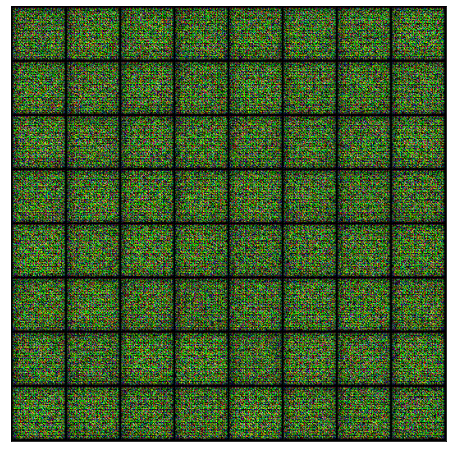

In [22]:
save_samples(0, fixed_latent)

This block defines the setting of the training of the GAN networks.Indeed this is the lock, where will define the hyperparameters of the trainig like the optmizer.In respect of this,we will use Adam optimizer for both of our networks.Besides,here will calculate all the relevant scores of the network. 

In [23]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

This block defines two very important hyperparameters--learning rate and epoch.And finally, we will fit the netowrk/train the netowork here.After the execution of this block,we will get our loss scores to see the performance of our designed model.

In [24]:
lr = 0.0002
epochs = 500
history = fit(epochs, lr)


Epoch [1/500], loss_g: 6.6623, loss_d: 0.0953, real_score: 0.9677, fake_score: 0.0591
Saving generated-images-0001.png



Epoch [2/500], loss_g: 12.0127, loss_d: 0.0231, real_score: 0.9781, fake_score: 0.0000
Saving generated-images-0002.png



Epoch [3/500], loss_g: 11.7411, loss_d: 0.0023, real_score: 0.9977, fake_score: 0.0000
Saving generated-images-0003.png



Epoch [4/500], loss_g: 7.8743, loss_d: 0.0027, real_score: 0.9977, fake_score: 0.0004
Saving generated-images-0004.png



Epoch [5/500], loss_g: 6.3842, loss_d: 0.0220, real_score: 0.9855, fake_score: 0.0048
Saving generated-images-0005.png



Epoch [6/500], loss_g: 12.3546, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-0006.png



Epoch [7/500], loss_g: 8.8851, loss_d: 0.0009, real_score: 0.9992, fake_score: 0.0001
Saving generated-images-0007.png



Epoch [8/500], loss_g: 8.5690, loss_d: 0.6909, real_score: 0.9898, fake_score: 0.4857
Saving generated-images-0008.png



Epoch [9/500], loss_g: 4.1648, loss_d: 0.0931, real_score: 0.9629, fake_score: 0.0517
Saving generated-images-0009.png



Epoch [10/500], loss_g: 6.1142, loss_d: 0.3841, real_score: 0.9324, fake_score: 0.2639
Saving generated-images-0010.png



Epoch [11/500], loss_g: 2.9644, loss_d: 1.0902, real_score: 0.7516, fake_score: 0.5155
Saving generated-images-0011.png



Epoch [12/500], loss_g: 3.7615, loss_d: 0.8674, real_score: 0.8627, fake_score: 0.4973
Saving generated-images-0012.png



Epoch [13/500], loss_g: 2.1843, loss_d: 0.5367, real_score: 0.6772, fake_score: 0.0709
Saving generated-images-0013.png



Epoch [14/500], loss_g: 3.7407, loss_d: 0.5002, real_score: 0.8065, fake_score: 0.2236
Saving generated-images-0014.png



Epoch [15/500], loss_g: 3.4760, loss_d: 0.2922, real_score: 0.8249, fake_score: 0.0855
Saving generated-images-0015.png



Epoch [16/500], loss_g: 3.7876, loss_d: 0.5334, real_score: 0.8387, fake_score: 0.2873
Saving generated-images-0016.png



Epoch [17/500], loss_g: 3.3029, loss_d: 0.6269, real_score: 0.5849, fake_score: 0.0270
Saving generated-images-0017.png



Epoch [18/500], loss_g: 2.5339, loss_d: 0.3738, real_score: 0.9043, fake_score: 0.2292
Saving generated-images-0018.png



Epoch [19/500], loss_g: 1.7550, loss_d: 1.0536, real_score: 0.4185, fake_score: 0.0638
Saving generated-images-0019.png



Epoch [20/500], loss_g: 2.9894, loss_d: 0.8621, real_score: 0.8605, fake_score: 0.4870
Saving generated-images-0020.png



Epoch [21/500], loss_g: 2.8363, loss_d: 0.4757, real_score: 0.7832, fake_score: 0.1877
Saving generated-images-0021.png



Epoch [22/500], loss_g: 2.9780, loss_d: 0.5247, real_score: 0.8559, fake_score: 0.2883
Saving generated-images-0022.png



Epoch [23/500], loss_g: 2.1472, loss_d: 0.6360, real_score: 0.6001, fake_score: 0.0647
Saving generated-images-0023.png



Epoch [24/500], loss_g: 4.0956, loss_d: 0.4451, real_score: 0.8807, fake_score: 0.2607
Saving generated-images-0024.png



Epoch [25/500], loss_g: 3.5089, loss_d: 0.4816, real_score: 0.8138, fake_score: 0.2249
Saving generated-images-0025.png



Epoch [26/500], loss_g: 3.8213, loss_d: 0.4620, real_score: 0.8780, fake_score: 0.2725
Saving generated-images-0026.png



Epoch [27/500], loss_g: 3.0978, loss_d: 0.6183, real_score: 0.8321, fake_score: 0.3365
Saving generated-images-0027.png



Epoch [28/500], loss_g: 3.6357, loss_d: 0.6575, real_score: 0.8224, fake_score: 0.3440
Saving generated-images-0028.png



Epoch [29/500], loss_g: 2.5869, loss_d: 0.8621, real_score: 0.5958, fake_score: 0.2286
Saving generated-images-0029.png



Epoch [30/500], loss_g: 2.7757, loss_d: 0.5869, real_score: 0.6448, fake_score: 0.1062
Saving generated-images-0030.png



Epoch [31/500], loss_g: 2.4113, loss_d: 0.5924, real_score: 0.7432, fake_score: 0.2192
Saving generated-images-0031.png



Epoch [32/500], loss_g: 3.0888, loss_d: 0.6070, real_score: 0.7890, fake_score: 0.2854
Saving generated-images-0032.png



Epoch [33/500], loss_g: 4.6968, loss_d: 1.0750, real_score: 0.9601, fake_score: 0.6021
Saving generated-images-0033.png



Epoch [34/500], loss_g: 1.6845, loss_d: 0.7236, real_score: 0.6577, fake_score: 0.2121
Saving generated-images-0034.png



Epoch [35/500], loss_g: 1.2143, loss_d: 0.8079, real_score: 0.5192, fake_score: 0.0573
Saving generated-images-0035.png



Epoch [36/500], loss_g: 3.5078, loss_d: 0.5899, real_score: 0.7873, fake_score: 0.2596
Saving generated-images-0036.png



Epoch [37/500], loss_g: 3.4091, loss_d: 0.4914, real_score: 0.8498, fake_score: 0.2680
Saving generated-images-0037.png



Epoch [38/500], loss_g: 5.2363, loss_d: 0.7709, real_score: 0.8471, fake_score: 0.4218
Saving generated-images-0038.png



Epoch [39/500], loss_g: 3.2777, loss_d: 0.3818, real_score: 0.8510, fake_score: 0.1845
Saving generated-images-0039.png



Epoch [40/500], loss_g: 3.2150, loss_d: 0.7227, real_score: 0.8030, fake_score: 0.3671
Saving generated-images-0040.png



Epoch [41/500], loss_g: 2.2279, loss_d: 0.6541, real_score: 0.6463, fake_score: 0.1320
Saving generated-images-0041.png



Epoch [42/500], loss_g: 2.6696, loss_d: 2.0455, real_score: 0.1720, fake_score: 0.0025
Saving generated-images-0042.png



Epoch [43/500], loss_g: 2.2579, loss_d: 0.4929, real_score: 0.7595, fake_score: 0.1305
Saving generated-images-0043.png



Epoch [44/500], loss_g: 3.6994, loss_d: 0.7580, real_score: 0.9164, fake_score: 0.4595
Saving generated-images-0044.png



Epoch [45/500], loss_g: 1.1793, loss_d: 0.8375, real_score: 0.5229, fake_score: 0.0615
Saving generated-images-0045.png



Epoch [46/500], loss_g: 2.3939, loss_d: 0.4678, real_score: 0.8406, fake_score: 0.2361
Saving generated-images-0046.png



Epoch [47/500], loss_g: 4.9795, loss_d: 0.4576, real_score: 0.9294, fake_score: 0.2998
Saving generated-images-0047.png



Epoch [48/500], loss_g: 1.4163, loss_d: 0.7652, real_score: 0.5375, fake_score: 0.0521
Saving generated-images-0048.png



Epoch [49/500], loss_g: 5.2129, loss_d: 1.0799, real_score: 0.9593, fake_score: 0.6088
Saving generated-images-0049.png



Epoch [50/500], loss_g: 0.9258, loss_d: 1.0501, real_score: 0.4068, fake_score: 0.0319
Saving generated-images-0050.png



Epoch [51/500], loss_g: 2.7636, loss_d: 0.4674, real_score: 0.7399, fake_score: 0.1285
Saving generated-images-0051.png



Epoch [52/500], loss_g: 2.0162, loss_d: 0.9548, real_score: 0.4294, fake_score: 0.0365
Saving generated-images-0052.png



Epoch [53/500], loss_g: 4.0466, loss_d: 0.3223, real_score: 0.7694, fake_score: 0.0364
Saving generated-images-0053.png



Epoch [54/500], loss_g: 3.3710, loss_d: 0.4717, real_score: 0.8291, fake_score: 0.2267
Saving generated-images-0054.png



Epoch [55/500], loss_g: 4.0075, loss_d: 0.5964, real_score: 0.8796, fake_score: 0.3527
Saving generated-images-0055.png



Epoch [56/500], loss_g: 3.5921, loss_d: 0.3829, real_score: 0.8718, fake_score: 0.2024
Saving generated-images-0056.png



Epoch [57/500], loss_g: 1.6402, loss_d: 0.6184, real_score: 0.6301, fake_score: 0.1031
Saving generated-images-0057.png



Epoch [58/500], loss_g: 3.2418, loss_d: 0.4549, real_score: 0.7217, fake_score: 0.0799
Saving generated-images-0058.png



Epoch [59/500], loss_g: 7.3665, loss_d: 1.3073, real_score: 0.9628, fake_score: 0.6710
Saving generated-images-0059.png



Epoch [60/500], loss_g: 1.4045, loss_d: 0.9866, real_score: 0.4323, fake_score: 0.0593
Saving generated-images-0060.png



Epoch [61/500], loss_g: 2.1647, loss_d: 0.7163, real_score: 0.6394, fake_score: 0.1849
Saving generated-images-0061.png



Epoch [62/500], loss_g: 0.5937, loss_d: 0.7555, real_score: 0.5426, fake_score: 0.0649
Saving generated-images-0062.png



Epoch [63/500], loss_g: 1.9102, loss_d: 0.8005, real_score: 0.5464, fake_score: 0.1024
Saving generated-images-0063.png



Epoch [64/500], loss_g: 3.4468, loss_d: 0.6874, real_score: 0.8023, fake_score: 0.3377
Saving generated-images-0064.png



Epoch [65/500], loss_g: 4.1631, loss_d: 0.6782, real_score: 0.9175, fake_score: 0.4093
Saving generated-images-0065.png



Epoch [66/500], loss_g: 3.1323, loss_d: 0.8044, real_score: 0.7463, fake_score: 0.3639
Saving generated-images-0066.png



Epoch [67/500], loss_g: 2.0693, loss_d: 2.4854, real_score: 0.1209, fake_score: 0.0015
Saving generated-images-0067.png



Epoch [68/500], loss_g: 2.0442, loss_d: 0.6441, real_score: 0.6506, fake_score: 0.1552
Saving generated-images-0068.png



Epoch [69/500], loss_g: 3.2572, loss_d: 0.5717, real_score: 0.7913, fake_score: 0.2546
Saving generated-images-0069.png



Epoch [70/500], loss_g: 2.8559, loss_d: 0.5935, real_score: 0.8533, fake_score: 0.3154
Saving generated-images-0070.png



Epoch [71/500], loss_g: 1.9794, loss_d: 0.7757, real_score: 0.6166, fake_score: 0.1854
Saving generated-images-0071.png



Epoch [72/500], loss_g: 3.6919, loss_d: 0.8397, real_score: 0.8053, fake_score: 0.4209
Saving generated-images-0072.png



Epoch [73/500], loss_g: 2.2421, loss_d: 0.6338, real_score: 0.7014, fake_score: 0.1973
Saving generated-images-0073.png



Epoch [74/500], loss_g: 3.8162, loss_d: 0.8492, real_score: 0.9226, fake_score: 0.4988
Saving generated-images-0074.png



Epoch [75/500], loss_g: 4.0350, loss_d: 0.6718, real_score: 0.9195, fake_score: 0.3943
Saving generated-images-0075.png



Epoch [76/500], loss_g: 2.1730, loss_d: 0.5657, real_score: 0.8129, fake_score: 0.2671
Saving generated-images-0076.png



Epoch [77/500], loss_g: 1.0811, loss_d: 0.8187, real_score: 0.5245, fake_score: 0.0840
Saving generated-images-0077.png



Epoch [78/500], loss_g: 3.5820, loss_d: 0.7019, real_score: 0.8743, fake_score: 0.3840
Saving generated-images-0078.png



Epoch [79/500], loss_g: 2.7465, loss_d: 0.5037, real_score: 0.7393, fake_score: 0.1538
Saving generated-images-0079.png



Epoch [80/500], loss_g: 1.1747, loss_d: 0.7060, real_score: 0.5856, fake_score: 0.0735
Saving generated-images-0080.png



Epoch [81/500], loss_g: 2.0005, loss_d: 0.6193, real_score: 0.9323, fake_score: 0.3830
Saving generated-images-0081.png



Epoch [82/500], loss_g: 3.7121, loss_d: 0.6715, real_score: 0.8385, fake_score: 0.3479
Saving generated-images-0082.png



Epoch [83/500], loss_g: 2.1769, loss_d: 0.6162, real_score: 0.6442, fake_score: 0.0803
Saving generated-images-0083.png



Epoch [84/500], loss_g: 1.7070, loss_d: 1.0550, real_score: 0.4323, fake_score: 0.0506
Saving generated-images-0084.png



Epoch [85/500], loss_g: 0.9304, loss_d: 0.7010, real_score: 0.5816, fake_score: 0.0901
Saving generated-images-0085.png



Epoch [86/500], loss_g: 1.2277, loss_d: 0.9183, real_score: 0.4900, fake_score: 0.0895
Saving generated-images-0086.png



Epoch [87/500], loss_g: 3.1510, loss_d: 0.4578, real_score: 0.8435, fake_score: 0.2324
Saving generated-images-0087.png



Epoch [88/500], loss_g: 3.8321, loss_d: 0.7273, real_score: 0.8808, fake_score: 0.4025
Saving generated-images-0088.png



Epoch [89/500], loss_g: 0.8730, loss_d: 0.9461, real_score: 0.4801, fake_score: 0.0980
Saving generated-images-0089.png



Epoch [90/500], loss_g: 1.5744, loss_d: 1.0323, real_score: 0.4270, fake_score: 0.0361
Saving generated-images-0090.png



Epoch [91/500], loss_g: 3.7822, loss_d: 0.5748, real_score: 0.9300, fake_score: 0.3622
Saving generated-images-0091.png



Epoch [92/500], loss_g: 2.6579, loss_d: 0.5311, real_score: 0.7544, fake_score: 0.1856
Saving generated-images-0092.png



Epoch [93/500], loss_g: 1.6322, loss_d: 0.6023, real_score: 0.6619, fake_score: 0.1239
Saving generated-images-0093.png



Epoch [94/500], loss_g: 5.0137, loss_d: 0.7182, real_score: 0.8754, fake_score: 0.3942
Saving generated-images-0094.png



Epoch [95/500], loss_g: 1.3256, loss_d: 0.5816, real_score: 0.6968, fake_score: 0.1452
Saving generated-images-0095.png



Epoch [96/500], loss_g: 3.5899, loss_d: 0.6303, real_score: 0.9450, fake_score: 0.3989
Saving generated-images-0096.png



Epoch [97/500], loss_g: 2.9231, loss_d: 0.5460, real_score: 0.8118, fake_score: 0.2474
Saving generated-images-0097.png



Epoch [98/500], loss_g: 3.1452, loss_d: 0.4605, real_score: 0.8540, fake_score: 0.2335
Saving generated-images-0098.png



Epoch [99/500], loss_g: 5.2210, loss_d: 0.7236, real_score: 0.9078, fake_score: 0.4168
Saving generated-images-0099.png



Epoch [100/500], loss_g: 3.2176, loss_d: 0.4285, real_score: 0.8495, fake_score: 0.2083
Saving generated-images-0100.png



Epoch [101/500], loss_g: 3.9236, loss_d: 0.6168, real_score: 0.8137, fake_score: 0.2832
Saving generated-images-0101.png



Epoch [102/500], loss_g: 6.6717, loss_d: 1.0042, real_score: 0.9171, fake_score: 0.5223
Saving generated-images-0102.png



Epoch [103/500], loss_g: 3.0564, loss_d: 0.5506, real_score: 0.8886, fake_score: 0.3113
Saving generated-images-0103.png



Epoch [104/500], loss_g: 2.0150, loss_d: 0.5359, real_score: 0.7014, fake_score: 0.1238
Saving generated-images-0104.png



Epoch [105/500], loss_g: 1.1446, loss_d: 0.7682, real_score: 0.5458, fake_score: 0.0293
Saving generated-images-0105.png



Epoch [106/500], loss_g: 2.4375, loss_d: 0.4583, real_score: 0.7489, fake_score: 0.1120
Saving generated-images-0106.png



Epoch [107/500], loss_g: 1.7137, loss_d: 0.4822, real_score: 0.7231, fake_score: 0.1039
Saving generated-images-0107.png



Epoch [108/500], loss_g: 2.6177, loss_d: 0.3468, real_score: 0.8175, fake_score: 0.1119
Saving generated-images-0108.png



Epoch [109/500], loss_g: 2.6724, loss_d: 0.3901, real_score: 0.7534, fake_score: 0.0706
Saving generated-images-0109.png



Epoch [110/500], loss_g: 1.0023, loss_d: 0.7446, real_score: 0.5388, fake_score: 0.0365
Saving generated-images-0110.png



Epoch [111/500], loss_g: 2.9861, loss_d: 0.3811, real_score: 0.8039, fake_score: 0.1228
Saving generated-images-0111.png



Epoch [112/500], loss_g: 3.0027, loss_d: 0.4716, real_score: 0.6848, fake_score: 0.0336
Saving generated-images-0112.png



Epoch [113/500], loss_g: 3.5792, loss_d: 0.2390, real_score: 0.8264, fake_score: 0.0380
Saving generated-images-0113.png



Epoch [114/500], loss_g: 2.9380, loss_d: 0.4219, real_score: 0.8940, fake_score: 0.2420
Saving generated-images-0114.png



Epoch [115/500], loss_g: 3.1548, loss_d: 0.5562, real_score: 0.8134, fake_score: 0.2539
Saving generated-images-0115.png



Epoch [116/500], loss_g: 3.3060, loss_d: 0.2455, real_score: 0.8585, fake_score: 0.0789
Saving generated-images-0116.png



Epoch [117/500], loss_g: 2.6373, loss_d: 1.5084, real_score: 0.3490, fake_score: 0.0241
Saving generated-images-0117.png



Epoch [118/500], loss_g: 3.7893, loss_d: 0.7036, real_score: 0.8646, fake_score: 0.3587
Saving generated-images-0118.png



Epoch [119/500], loss_g: 4.4125, loss_d: 0.5538, real_score: 0.9148, fake_score: 0.3348
Saving generated-images-0119.png



Epoch [120/500], loss_g: 4.5287, loss_d: 0.5119, real_score: 0.9396, fake_score: 0.3277
Saving generated-images-0120.png



Epoch [121/500], loss_g: 2.7358, loss_d: 0.3586, real_score: 0.8159, fake_score: 0.1158
Saving generated-images-0121.png



Epoch [122/500], loss_g: 3.5117, loss_d: 0.2435, real_score: 0.8833, fake_score: 0.0993
Saving generated-images-0122.png



Epoch [123/500], loss_g: 5.0127, loss_d: 0.7532, real_score: 0.9747, fake_score: 0.4227
Saving generated-images-0123.png



Epoch [124/500], loss_g: 4.8125, loss_d: 0.5651, real_score: 0.9052, fake_score: 0.3358
Saving generated-images-0124.png



Epoch [125/500], loss_g: 1.3783, loss_d: 1.0877, real_score: 0.4133, fake_score: 0.0077
Saving generated-images-0125.png



Epoch [126/500], loss_g: 2.8671, loss_d: 0.3120, real_score: 0.8081, fake_score: 0.0705
Saving generated-images-0126.png



Epoch [127/500], loss_g: 2.9270, loss_d: 0.3136, real_score: 0.8182, fake_score: 0.0859
Saving generated-images-0127.png



Epoch [128/500], loss_g: 4.3627, loss_d: 0.2899, real_score: 0.8014, fake_score: 0.0392
Saving generated-images-0128.png



Epoch [129/500], loss_g: 1.9871, loss_d: 0.6656, real_score: 0.6099, fake_score: 0.0430
Saving generated-images-0129.png



Epoch [130/500], loss_g: 4.2107, loss_d: 0.3501, real_score: 0.8903, fake_score: 0.1810
Saving generated-images-0130.png



Epoch [131/500], loss_g: 4.1558, loss_d: 0.3554, real_score: 0.9295, fake_score: 0.2041
Saving generated-images-0131.png



Epoch [132/500], loss_g: 2.6876, loss_d: 0.3714, real_score: 0.7777, fake_score: 0.0737
Saving generated-images-0132.png



Epoch [133/500], loss_g: 0.6809, loss_d: 1.1637, real_score: 0.3799, fake_score: 0.0065
Saving generated-images-0133.png



Epoch [134/500], loss_g: 3.7199, loss_d: 0.3382, real_score: 0.9082, fake_score: 0.1855
Saving generated-images-0134.png



Epoch [135/500], loss_g: 3.5391, loss_d: 0.3406, real_score: 0.8620, fake_score: 0.1440
Saving generated-images-0135.png



Epoch [136/500], loss_g: 3.1053, loss_d: 0.2835, real_score: 0.7991, fake_score: 0.0337
Saving generated-images-0136.png



Epoch [137/500], loss_g: 3.4625, loss_d: 0.3166, real_score: 0.8622, fake_score: 0.1370
Saving generated-images-0137.png



Epoch [138/500], loss_g: 5.7783, loss_d: 0.4426, real_score: 0.9714, fake_score: 0.2980
Saving generated-images-0138.png



Epoch [139/500], loss_g: 3.7131, loss_d: 0.5501, real_score: 0.8619, fake_score: 0.2728
Saving generated-images-0139.png



Epoch [140/500], loss_g: 2.2591, loss_d: 0.7761, real_score: 0.5661, fake_score: 0.0613
Saving generated-images-0140.png



Epoch [141/500], loss_g: 3.6018, loss_d: 0.3772, real_score: 0.7816, fake_score: 0.0713
Saving generated-images-0141.png



Epoch [142/500], loss_g: 2.9537, loss_d: 0.3369, real_score: 0.8353, fake_score: 0.1106
Saving generated-images-0142.png



Epoch [143/500], loss_g: 4.4000, loss_d: 0.3972, real_score: 0.9432, fake_score: 0.2504
Saving generated-images-0143.png



Epoch [144/500], loss_g: 4.6960, loss_d: 0.2842, real_score: 0.9476, fake_score: 0.1811
Saving generated-images-0144.png



Epoch [145/500], loss_g: 2.9569, loss_d: 0.3723, real_score: 0.8060, fake_score: 0.1020
Saving generated-images-0145.png



Epoch [146/500], loss_g: 4.8082, loss_d: 0.2767, real_score: 0.9531, fake_score: 0.1837
Saving generated-images-0146.png



Epoch [147/500], loss_g: 4.2579, loss_d: 0.2573, real_score: 0.9627, fake_score: 0.1770
Saving generated-images-0147.png



Epoch [148/500], loss_g: 3.1458, loss_d: 0.2034, real_score: 0.8950, fake_score: 0.0731
Saving generated-images-0148.png



Epoch [149/500], loss_g: 2.4905, loss_d: 0.3889, real_score: 0.7391, fake_score: 0.0326
Saving generated-images-0149.png



Epoch [150/500], loss_g: 3.4225, loss_d: 0.2479, real_score: 0.8866, fake_score: 0.1005
Saving generated-images-0150.png



Epoch [151/500], loss_g: 4.3746, loss_d: 0.1710, real_score: 0.8816, fake_score: 0.0319
Saving generated-images-0151.png



Epoch [152/500], loss_g: 4.4407, loss_d: 0.2727, real_score: 0.8941, fake_score: 0.1211
Saving generated-images-0152.png



Epoch [153/500], loss_g: 2.9533, loss_d: 0.9335, real_score: 0.9117, fake_score: 0.4473
Saving generated-images-0153.png



Epoch [154/500], loss_g: 3.6144, loss_d: 0.4709, real_score: 0.7778, fake_score: 0.1482
Saving generated-images-0154.png



Epoch [155/500], loss_g: 3.2458, loss_d: 0.3778, real_score: 0.8483, fake_score: 0.1472
Saving generated-images-0155.png



Epoch [156/500], loss_g: 2.8594, loss_d: 0.3048, real_score: 0.8235, fake_score: 0.0800
Saving generated-images-0156.png



Epoch [157/500], loss_g: 2.7252, loss_d: 0.2563, real_score: 0.8637, fake_score: 0.0759
Saving generated-images-0157.png



Epoch [158/500], loss_g: 2.8463, loss_d: 0.2564, real_score: 0.8412, fake_score: 0.0592
Saving generated-images-0158.png



Epoch [159/500], loss_g: 3.8212, loss_d: 0.2377, real_score: 0.9576, fake_score: 0.1656
Saving generated-images-0159.png



Epoch [160/500], loss_g: 3.6742, loss_d: 0.2547, real_score: 0.8960, fake_score: 0.1182
Saving generated-images-0160.png



Epoch [161/500], loss_g: 2.7889, loss_d: 0.4769, real_score: 0.6678, fake_score: 0.0079
Saving generated-images-0161.png



Epoch [162/500], loss_g: 4.1434, loss_d: 0.2158, real_score: 0.9368, fake_score: 0.1246
Saving generated-images-0162.png



Epoch [163/500], loss_g: 4.2247, loss_d: 0.1611, real_score: 0.9269, fake_score: 0.0727
Saving generated-images-0163.png



Epoch [164/500], loss_g: 4.3036, loss_d: 0.1407, real_score: 0.9371, fake_score: 0.0678
Saving generated-images-0164.png



Epoch [165/500], loss_g: 2.8317, loss_d: 0.4304, real_score: 0.6994, fake_score: 0.0126
Saving generated-images-0165.png



Epoch [166/500], loss_g: 3.3331, loss_d: 0.1900, real_score: 0.9317, fake_score: 0.0948
Saving generated-images-0166.png



Epoch [167/500], loss_g: 3.9046, loss_d: 0.2627, real_score: 0.9876, fake_score: 0.1913
Saving generated-images-0167.png



Epoch [168/500], loss_g: 7.8492, loss_d: 0.4895, real_score: 0.9799, fake_score: 0.3372
Saving generated-images-0168.png



Epoch [169/500], loss_g: 4.0770, loss_d: 0.2013, real_score: 0.9447, fake_score: 0.1219
Saving generated-images-0169.png



Epoch [170/500], loss_g: 2.3531, loss_d: 0.3210, real_score: 0.8017, fake_score: 0.0474
Saving generated-images-0170.png



Epoch [171/500], loss_g: 3.9883, loss_d: 0.1840, real_score: 0.9167, fake_score: 0.0810
Saving generated-images-0171.png



Epoch [172/500], loss_g: 5.3206, loss_d: 0.2719, real_score: 0.9575, fake_score: 0.1774
Saving generated-images-0172.png



Epoch [173/500], loss_g: 5.6489, loss_d: 0.1775, real_score: 0.9706, fake_score: 0.1212
Saving generated-images-0173.png



Epoch [174/500], loss_g: 3.7596, loss_d: 0.1255, real_score: 0.9422, fake_score: 0.0551
Saving generated-images-0174.png



Epoch [175/500], loss_g: 4.2871, loss_d: 0.1170, real_score: 0.9191, fake_score: 0.0269
Saving generated-images-0175.png



Epoch [176/500], loss_g: 4.3937, loss_d: 0.1764, real_score: 0.8800, fake_score: 0.0274
Saving generated-images-0176.png



Epoch [177/500], loss_g: 3.9176, loss_d: 0.1625, real_score: 0.9342, fake_score: 0.0795
Saving generated-images-0177.png



Epoch [178/500], loss_g: 3.3810, loss_d: 0.2969, real_score: 0.7952, fake_score: 0.0175
Saving generated-images-0178.png



Epoch [179/500], loss_g: 5.7001, loss_d: 0.2102, real_score: 0.9782, fake_score: 0.1451
Saving generated-images-0179.png



Epoch [180/500], loss_g: 2.9751, loss_d: 0.2393, real_score: 0.8556, fake_score: 0.0552
Saving generated-images-0180.png



Epoch [181/500], loss_g: 3.1193, loss_d: 0.2212, real_score: 0.8317, fake_score: 0.0167
Saving generated-images-0181.png



Epoch [182/500], loss_g: 12.0517, loss_d: 4.2322, real_score: 0.9996, fake_score: 0.9386
Saving generated-images-0182.png



Epoch [183/500], loss_g: 5.4615, loss_d: 0.7388, real_score: 0.8921, fake_score: 0.3263
Saving generated-images-0183.png



Epoch [184/500], loss_g: 4.8014, loss_d: 0.2538, real_score: 0.8999, fake_score: 0.1045
Saving generated-images-0184.png



Epoch [185/500], loss_g: 3.8246, loss_d: 0.2977, real_score: 0.8110, fake_score: 0.0423
Saving generated-images-0185.png



Epoch [186/500], loss_g: 4.8408, loss_d: 0.2351, real_score: 0.9686, fake_score: 0.1663
Saving generated-images-0186.png



Epoch [187/500], loss_g: 3.4244, loss_d: 0.1473, real_score: 0.9150, fake_score: 0.0476
Saving generated-images-0187.png



Epoch [188/500], loss_g: 4.9882, loss_d: 0.1823, real_score: 0.9649, fake_score: 0.1274
Saving generated-images-0188.png



Epoch [189/500], loss_g: 4.7531, loss_d: 0.1731, real_score: 0.9128, fake_score: 0.0623
Saving generated-images-0189.png



Epoch [190/500], loss_g: 3.9745, loss_d: 0.0939, real_score: 0.9602, fake_score: 0.0484
Saving generated-images-0190.png



Epoch [191/500], loss_g: 5.0839, loss_d: 0.1312, real_score: 0.9741, fake_score: 0.0935
Saving generated-images-0191.png



Epoch [192/500], loss_g: 4.7495, loss_d: 0.1469, real_score: 0.9760, fake_score: 0.1087
Saving generated-images-0192.png



Epoch [193/500], loss_g: 3.5753, loss_d: 0.1190, real_score: 0.9250, fake_score: 0.0349
Saving generated-images-0193.png



Epoch [194/500], loss_g: 5.7867, loss_d: 0.1680, real_score: 0.9774, fake_score: 0.1194
Saving generated-images-0194.png



Epoch [195/500], loss_g: 2.3534, loss_d: 0.2935, real_score: 0.7771, fake_score: 0.0089
Saving generated-images-0195.png



Epoch [196/500], loss_g: 4.5681, loss_d: 0.1471, real_score: 0.9623, fake_score: 0.0932
Saving generated-images-0196.png



Epoch [197/500], loss_g: 9.0786, loss_d: 1.3789, real_score: 0.9973, fake_score: 0.5573
Saving generated-images-0197.png



Epoch [198/500], loss_g: 5.0344, loss_d: 0.3694, real_score: 0.8718, fake_score: 0.1393
Saving generated-images-0198.png



Epoch [199/500], loss_g: 4.6939, loss_d: 0.1816, real_score: 0.8762, fake_score: 0.0281
Saving generated-images-0199.png



Epoch [200/500], loss_g: 5.4403, loss_d: 0.2279, real_score: 0.9770, fake_score: 0.1677
Saving generated-images-0200.png



Epoch [201/500], loss_g: 4.2160, loss_d: 0.1933, real_score: 0.8964, fake_score: 0.0624
Saving generated-images-0201.png



Epoch [202/500], loss_g: 6.0890, loss_d: 0.1915, real_score: 0.9729, fake_score: 0.1319
Saving generated-images-0202.png



Epoch [203/500], loss_g: 4.8631, loss_d: 0.0966, real_score: 0.9478, fake_score: 0.0389
Saving generated-images-0203.png



Epoch [204/500], loss_g: 4.5463, loss_d: 0.0856, real_score: 0.9849, fake_score: 0.0634
Saving generated-images-0204.png



Epoch [205/500], loss_g: 5.1922, loss_d: 0.1304, real_score: 0.9864, fake_score: 0.0977
Saving generated-images-0205.png



Epoch [206/500], loss_g: 3.7801, loss_d: 0.0744, real_score: 0.9638, fake_score: 0.0338
Saving generated-images-0206.png



Epoch [207/500], loss_g: 3.7677, loss_d: 0.1112, real_score: 0.9285, fake_score: 0.0303
Saving generated-images-0207.png



Epoch [208/500], loss_g: 5.4792, loss_d: 0.1203, real_score: 0.9814, fake_score: 0.0874
Saving generated-images-0208.png



Epoch [209/500], loss_g: 4.2026, loss_d: 0.0881, real_score: 0.9566, fake_score: 0.0389
Saving generated-images-0209.png



Epoch [210/500], loss_g: 3.9464, loss_d: 0.0822, real_score: 0.9472, fake_score: 0.0238
Saving generated-images-0210.png



Epoch [211/500], loss_g: 4.6985, loss_d: 0.0554, real_score: 0.9822, fake_score: 0.0354
Saving generated-images-0211.png



Epoch [212/500], loss_g: 4.8320, loss_d: 0.0749, real_score: 0.9682, fake_score: 0.0393
Saving generated-images-0212.png



Epoch [213/500], loss_g: 4.6736, loss_d: 0.0591, real_score: 0.9805, fake_score: 0.0376
Saving generated-images-0213.png



Epoch [214/500], loss_g: 4.0810, loss_d: 0.0834, real_score: 0.9450, fake_score: 0.0221
Saving generated-images-0214.png



Epoch [215/500], loss_g: 3.6290, loss_d: 0.0998, real_score: 0.9251, fake_score: 0.0171
Saving generated-images-0215.png



Epoch [216/500], loss_g: 1.7525, loss_d: 0.7072, real_score: 0.7035, fake_score: 0.1700
Saving generated-images-0216.png



Epoch [217/500], loss_g: 2.2888, loss_d: 0.5943, real_score: 0.7521, fake_score: 0.1602
Saving generated-images-0217.png



Epoch [218/500], loss_g: 4.4742, loss_d: 0.3873, real_score: 0.7882, fake_score: 0.0633
Saving generated-images-0218.png



Epoch [219/500], loss_g: 4.6223, loss_d: 0.2611, real_score: 0.9205, fake_score: 0.1349
Saving generated-images-0219.png



Epoch [220/500], loss_g: 4.8396, loss_d: 0.2631, real_score: 0.9093, fake_score: 0.1289
Saving generated-images-0220.png



Epoch [221/500], loss_g: 5.9646, loss_d: 0.2343, real_score: 0.9740, fake_score: 0.1647
Saving generated-images-0221.png



Epoch [222/500], loss_g: 5.0535, loss_d: 0.2408, real_score: 0.9562, fake_score: 0.1320
Saving generated-images-0222.png



Epoch [223/500], loss_g: 4.3098, loss_d: 0.1161, real_score: 0.9319, fake_score: 0.0386
Saving generated-images-0223.png



Epoch [224/500], loss_g: 4.6518, loss_d: 0.1112, real_score: 0.9617, fake_score: 0.0654
Saving generated-images-0224.png



Epoch [225/500], loss_g: 4.3957, loss_d: 0.1101, real_score: 0.9835, fake_score: 0.0827
Saving generated-images-0225.png



Epoch [226/500], loss_g: 4.4073, loss_d: 0.0950, real_score: 0.9407, fake_score: 0.0302
Saving generated-images-0226.png



Epoch [227/500], loss_g: 3.5115, loss_d: 0.1237, real_score: 0.9188, fake_score: 0.0309
Saving generated-images-0227.png



Epoch [228/500], loss_g: 4.5258, loss_d: 0.1148, real_score: 0.9178, fake_score: 0.0181
Saving generated-images-0228.png



Epoch [229/500], loss_g: 4.5442, loss_d: 0.0676, real_score: 0.9537, fake_score: 0.0181
Saving generated-images-0229.png



Epoch [230/500], loss_g: 4.1177, loss_d: 0.0845, real_score: 0.9562, fake_score: 0.0366
Saving generated-images-0230.png



Epoch [231/500], loss_g: 4.4700, loss_d: 0.0908, real_score: 0.9324, fake_score: 0.0165
Saving generated-images-0231.png



Epoch [232/500], loss_g: 4.6558, loss_d: 0.0588, real_score: 0.9756, fake_score: 0.0318
Saving generated-images-0232.png



Epoch [233/500], loss_g: 4.2664, loss_d: 0.0805, real_score: 0.9556, fake_score: 0.0319
Saving generated-images-0233.png



Epoch [234/500], loss_g: 4.1850, loss_d: 0.0640, real_score: 0.9630, fake_score: 0.0247
Saving generated-images-0234.png



Epoch [235/500], loss_g: 5.3038, loss_d: 0.1030, real_score: 0.9132, fake_score: 0.0062
Saving generated-images-0235.png



Epoch [236/500], loss_g: 3.8473, loss_d: 0.1328, real_score: 0.8965, fake_score: 0.0139
Saving generated-images-0236.png



Epoch [237/500], loss_g: 4.4938, loss_d: 0.0764, real_score: 0.9426, fake_score: 0.0143
Saving generated-images-0237.png



Epoch [238/500], loss_g: 6.0198, loss_d: 0.4175, real_score: 0.9790, fake_score: 0.2345
Saving generated-images-0238.png



Epoch [239/500], loss_g: 4.3005, loss_d: 0.2462, real_score: 0.9371, fake_score: 0.1170
Saving generated-images-0239.png



Epoch [240/500], loss_g: 4.1483, loss_d: 0.1516, real_score: 0.9291, fake_score: 0.0594
Saving generated-images-0240.png



Epoch [241/500], loss_g: 5.0068, loss_d: 0.1321, real_score: 0.9652, fake_score: 0.0827
Saving generated-images-0241.png



Epoch [242/500], loss_g: 4.8494, loss_d: 0.0685, real_score: 0.9570, fake_score: 0.0221
Saving generated-images-0242.png



Epoch [243/500], loss_g: 2.3076, loss_d: 0.1841, real_score: 0.8632, fake_score: 0.0197
Saving generated-images-0243.png



Epoch [244/500], loss_g: 3.9842, loss_d: 0.4837, real_score: 0.7326, fake_score: 0.0427
Saving generated-images-0244.png



Epoch [245/500], loss_g: 6.2701, loss_d: 0.2890, real_score: 0.9799, fake_score: 0.1848
Saving generated-images-0245.png



Epoch [246/500], loss_g: 4.0296, loss_d: 0.1552, real_score: 0.9053, fake_score: 0.0424
Saving generated-images-0246.png



Epoch [247/500], loss_g: 5.2465, loss_d: 0.1263, real_score: 0.8975, fake_score: 0.0105
Saving generated-images-0247.png



Epoch [248/500], loss_g: 4.7965, loss_d: 0.1062, real_score: 0.9553, fake_score: 0.0467
Saving generated-images-0248.png



Epoch [249/500], loss_g: 5.0931, loss_d: 0.1300, real_score: 0.9561, fake_score: 0.0705
Saving generated-images-0249.png



Epoch [250/500], loss_g: 5.0362, loss_d: 0.0603, real_score: 0.9779, fake_score: 0.0340
Saving generated-images-0250.png



Epoch [251/500], loss_g: 4.4889, loss_d: 0.0634, real_score: 0.9781, fake_score: 0.0380
Saving generated-images-0251.png



Epoch [252/500], loss_g: 5.2613, loss_d: 0.0715, real_score: 0.9862, fake_score: 0.0539
Saving generated-images-0252.png



Epoch [253/500], loss_g: 4.7426, loss_d: 0.0488, real_score: 0.9689, fake_score: 0.0159
Saving generated-images-0253.png



Epoch [254/500], loss_g: 4.8865, loss_d: 0.0506, real_score: 0.9649, fake_score: 0.0133
Saving generated-images-0254.png



Epoch [255/500], loss_g: 5.0689, loss_d: 0.0418, real_score: 0.9773, fake_score: 0.0180
Saving generated-images-0255.png



Epoch [256/500], loss_g: 4.8841, loss_d: 0.0492, real_score: 0.9785, fake_score: 0.0262
Saving generated-images-0256.png



Epoch [257/500], loss_g: 4.6784, loss_d: 0.0549, real_score: 0.9837, fake_score: 0.0362
Saving generated-images-0257.png



Epoch [258/500], loss_g: 4.5146, loss_d: 0.0437, real_score: 0.9797, fake_score: 0.0220
Saving generated-images-0258.png



Epoch [259/500], loss_g: 4.9962, loss_d: 0.0388, real_score: 0.9801, fake_score: 0.0179
Saving generated-images-0259.png



Epoch [260/500], loss_g: 5.5411, loss_d: 0.0450, real_score: 0.9826, fake_score: 0.0265
Saving generated-images-0260.png



Epoch [261/500], loss_g: 5.2917, loss_d: 0.0687, real_score: 0.9783, fake_score: 0.0417
Saving generated-images-0261.png



Epoch [262/500], loss_g: 4.8864, loss_d: 0.0475, real_score: 0.9708, fake_score: 0.0169
Saving generated-images-0262.png



Epoch [263/500], loss_g: 5.1947, loss_d: 0.0299, real_score: 0.9903, fake_score: 0.0191
Saving generated-images-0263.png



Epoch [264/500], loss_g: 5.7523, loss_d: 0.0391, real_score: 0.9871, fake_score: 0.0249
Saving generated-images-0264.png



Epoch [265/500], loss_g: 5.5340, loss_d: 0.0243, real_score: 0.9859, fake_score: 0.0099
Saving generated-images-0265.png



Epoch [266/500], loss_g: 5.3431, loss_d: 0.0349, real_score: 0.9767, fake_score: 0.0109
Saving generated-images-0266.png



Epoch [267/500], loss_g: 5.5755, loss_d: 0.0330, real_score: 0.9892, fake_score: 0.0212
Saving generated-images-0267.png



Epoch [268/500], loss_g: 5.9286, loss_d: 0.0397, real_score: 0.9871, fake_score: 0.0257
Saving generated-images-0268.png



Epoch [269/500], loss_g: 5.2649, loss_d: 0.0473, real_score: 0.9726, fake_score: 0.0176
Saving generated-images-0269.png



Epoch [270/500], loss_g: 5.0845, loss_d: 0.0591, real_score: 0.9554, fake_score: 0.0096
Saving generated-images-0270.png



Epoch [271/500], loss_g: 4.8698, loss_d: 0.0361, real_score: 0.9922, fake_score: 0.0273
Saving generated-images-0271.png



Epoch [272/500], loss_g: 5.2042, loss_d: 0.0324, real_score: 0.9841, fake_score: 0.0160
Saving generated-images-0272.png



Epoch [273/500], loss_g: 4.7525, loss_d: 0.0435, real_score: 0.9740, fake_score: 0.0163
Saving generated-images-0273.png



Epoch [274/500], loss_g: 6.3498, loss_d: 0.0287, real_score: 0.9790, fake_score: 0.0068
Saving generated-images-0274.png



Epoch [275/500], loss_g: 5.0637, loss_d: 0.1106, real_score: 0.9991, fake_score: 0.0967
Saving generated-images-0275.png



Epoch [276/500], loss_g: 3.9939, loss_d: 0.1115, real_score: 0.9155, fake_score: 0.0092
Saving generated-images-0276.png



Epoch [277/500], loss_g: 4.9686, loss_d: 0.0863, real_score: 0.9683, fake_score: 0.0454
Saving generated-images-0277.png



Epoch [278/500], loss_g: 5.5004, loss_d: 0.0710, real_score: 0.9789, fake_score: 0.0449
Saving generated-images-0278.png



Epoch [279/500], loss_g: 5.6295, loss_d: 0.0893, real_score: 0.9719, fake_score: 0.0531
Saving generated-images-0279.png



Epoch [280/500], loss_g: 5.3277, loss_d: 0.0426, real_score: 0.9751, fake_score: 0.0160
Saving generated-images-0280.png



Epoch [281/500], loss_g: 5.9471, loss_d: 0.0365, real_score: 0.9866, fake_score: 0.0220
Saving generated-images-0281.png



Epoch [282/500], loss_g: 4.7843, loss_d: 0.0575, real_score: 0.9605, fake_score: 0.0147
Saving generated-images-0282.png



Epoch [283/500], loss_g: 4.3705, loss_d: 0.0699, real_score: 0.9433, fake_score: 0.0068
Saving generated-images-0283.png



Epoch [284/500], loss_g: 5.6766, loss_d: 0.0339, real_score: 0.9897, fake_score: 0.0224
Saving generated-images-0284.png



Epoch [285/500], loss_g: 6.5076, loss_d: 0.0517, real_score: 0.9864, fake_score: 0.0359
Saving generated-images-0285.png



Epoch [286/500], loss_g: 4.4341, loss_d: 0.0541, real_score: 0.9553, fake_score: 0.0070
Saving generated-images-0286.png



Epoch [287/500], loss_g: 5.4492, loss_d: 0.0288, real_score: 0.9854, fake_score: 0.0137
Saving generated-images-0287.png



Epoch [288/500], loss_g: 5.2164, loss_d: 0.0311, real_score: 0.9915, fake_score: 0.0218
Saving generated-images-0288.png



Epoch [289/500], loss_g: 5.3819, loss_d: 0.0289, real_score: 0.9826, fake_score: 0.0109
Saving generated-images-0289.png



Epoch [290/500], loss_g: 5.4597, loss_d: 0.0277, real_score: 0.9873, fake_score: 0.0146
Saving generated-images-0290.png



Epoch [291/500], loss_g: 5.6400, loss_d: 0.0404, real_score: 0.9730, fake_score: 0.0117
Saving generated-images-0291.png



Epoch [292/500], loss_g: 5.1704, loss_d: 0.0231, real_score: 0.9892, fake_score: 0.0119
Saving generated-images-0292.png



Epoch [293/500], loss_g: 5.7122, loss_d: 0.0274, real_score: 0.9841, fake_score: 0.0109
Saving generated-images-0293.png



Epoch [294/500], loss_g: 5.3593, loss_d: 0.0223, real_score: 0.9867, fake_score: 0.0087
Saving generated-images-0294.png



Epoch [295/500], loss_g: 5.6942, loss_d: 0.0253, real_score: 0.9832, fake_score: 0.0082
Saving generated-images-0295.png



Epoch [296/500], loss_g: 5.7559, loss_d: 0.0247, real_score: 0.9894, fake_score: 0.0136
Saving generated-images-0296.png



Epoch [297/500], loss_g: 6.3044, loss_d: 0.0336, real_score: 0.9954, fake_score: 0.0276
Saving generated-images-0297.png



Epoch [298/500], loss_g: 5.3671, loss_d: 0.0357, real_score: 0.9858, fake_score: 0.0206
Saving generated-images-0298.png



Epoch [299/500], loss_g: 5.9089, loss_d: 0.0405, real_score: 0.9876, fake_score: 0.0268
Saving generated-images-0299.png



Epoch [300/500], loss_g: 5.2471, loss_d: 0.0287, real_score: 0.9833, fake_score: 0.0114
Saving generated-images-0300.png



Epoch [301/500], loss_g: 6.0577, loss_d: 0.0198, real_score: 0.9900, fake_score: 0.0095
Saving generated-images-0301.png



Epoch [302/500], loss_g: 5.2514, loss_d: 0.0276, real_score: 0.9862, fake_score: 0.0133
Saving generated-images-0302.png



Epoch [303/500], loss_g: 4.5586, loss_d: 0.0332, real_score: 0.9799, fake_score: 0.0119
Saving generated-images-0303.png



Epoch [304/500], loss_g: 5.0070, loss_d: 0.0266, real_score: 0.9821, fake_score: 0.0081
Saving generated-images-0304.png



Epoch [305/500], loss_g: 5.1259, loss_d: 0.0190, real_score: 0.9908, fake_score: 0.0096
Saving generated-images-0305.png



Epoch [306/500], loss_g: 5.5349, loss_d: 0.0247, real_score: 0.9847, fake_score: 0.0090
Saving generated-images-0306.png



Epoch [307/500], loss_g: 6.0180, loss_d: 0.0244, real_score: 0.9852, fake_score: 0.0093
Saving generated-images-0307.png



Epoch [308/500], loss_g: 5.4331, loss_d: 0.0215, real_score: 0.9822, fake_score: 0.0033
Saving generated-images-0308.png



Epoch [309/500], loss_g: 5.7113, loss_d: 0.0311, real_score: 0.9946, fake_score: 0.0248
Saving generated-images-0309.png



Epoch [310/500], loss_g: 2.5091, loss_d: 1.5698, real_score: 0.5006, fake_score: 0.1752
Saving generated-images-0310.png



Epoch [311/500], loss_g: 3.3494, loss_d: 1.4571, real_score: 0.8707, fake_score: 0.6394
Saving generated-images-0311.png



Epoch [312/500], loss_g: 2.7911, loss_d: 1.1522, real_score: 0.8143, fake_score: 0.5131
Saving generated-images-0312.png



Epoch [313/500], loss_g: 1.4963, loss_d: 0.9898, real_score: 0.5494, fake_score: 0.1245
Saving generated-images-0313.png



Epoch [314/500], loss_g: 5.4891, loss_d: 0.7400, real_score: 0.8820, fake_score: 0.3473
Saving generated-images-0314.png



Epoch [315/500], loss_g: 2.6134, loss_d: 0.6640, real_score: 0.8796, fake_score: 0.3169
Saving generated-images-0315.png



Epoch [316/500], loss_g: 3.0609, loss_d: 0.5427, real_score: 0.7587, fake_score: 0.1386
Saving generated-images-0316.png



Epoch [317/500], loss_g: 5.9048, loss_d: 0.5603, real_score: 0.9298, fake_score: 0.3015
Saving generated-images-0317.png



Epoch [318/500], loss_g: 4.1499, loss_d: 0.3073, real_score: 0.9186, fake_score: 0.1563
Saving generated-images-0318.png



Epoch [319/500], loss_g: 4.8540, loss_d: 0.3383, real_score: 0.8914, fake_score: 0.1441
Saving generated-images-0319.png



Epoch [320/500], loss_g: 6.1494, loss_d: 0.3534, real_score: 0.9570, fake_score: 0.2135
Saving generated-images-0320.png



Epoch [321/500], loss_g: 3.7339, loss_d: 0.3864, real_score: 0.8323, fake_score: 0.0983
Saving generated-images-0321.png



Epoch [322/500], loss_g: 5.7710, loss_d: 0.4511, real_score: 0.9460, fake_score: 0.2415
Saving generated-images-0322.png



Epoch [323/500], loss_g: 5.2118, loss_d: 0.4312, real_score: 0.7466, fake_score: 0.0096
Saving generated-images-0323.png



Epoch [324/500], loss_g: 4.9699, loss_d: 0.1712, real_score: 0.9698, fake_score: 0.1124
Saving generated-images-0324.png



Epoch [325/500], loss_g: 4.5143, loss_d: 0.1181, real_score: 0.9674, fake_score: 0.0724
Saving generated-images-0325.png



Epoch [326/500], loss_g: 4.0589, loss_d: 0.1707, real_score: 0.9612, fake_score: 0.1124
Saving generated-images-0326.png



Epoch [327/500], loss_g: 7.8413, loss_d: 0.3640, real_score: 0.9821, fake_score: 0.2425
Saving generated-images-0327.png



Epoch [328/500], loss_g: 4.5196, loss_d: 0.1638, real_score: 0.8890, fake_score: 0.0211
Saving generated-images-0328.png



Epoch [329/500], loss_g: 5.1633, loss_d: 0.1143, real_score: 0.9550, fake_score: 0.0606
Saving generated-images-0329.png



Epoch [330/500], loss_g: 6.1283, loss_d: 0.1573, real_score: 0.9690, fake_score: 0.1047
Saving generated-images-0330.png



Epoch [331/500], loss_g: 4.3743, loss_d: 0.1134, real_score: 0.9319, fake_score: 0.0225
Saving generated-images-0331.png



Epoch [332/500], loss_g: 4.3998, loss_d: 0.1281, real_score: 0.9108, fake_score: 0.0241
Saving generated-images-0332.png



Epoch [333/500], loss_g: 5.1817, loss_d: 0.0980, real_score: 0.9803, fake_score: 0.0685
Saving generated-images-0333.png



Epoch [334/500], loss_g: 6.8062, loss_d: 0.0950, real_score: 0.9776, fake_score: 0.0652
Saving generated-images-0334.png



Epoch [335/500], loss_g: 5.1451, loss_d: 0.0590, real_score: 0.9774, fake_score: 0.0334
Saving generated-images-0335.png



Epoch [336/500], loss_g: 5.6335, loss_d: 0.0472, real_score: 0.9819, fake_score: 0.0273
Saving generated-images-0336.png



Epoch [337/500], loss_g: 5.1197, loss_d: 0.0725, real_score: 0.9853, fake_score: 0.0529
Saving generated-images-0337.png



Epoch [338/500], loss_g: 6.2109, loss_d: 0.0430, real_score: 0.9866, fake_score: 0.0268
Saving generated-images-0338.png



Epoch [339/500], loss_g: 6.1629, loss_d: 0.0811, real_score: 0.9881, fake_score: 0.0629
Saving generated-images-0339.png



Epoch [340/500], loss_g: 4.9375, loss_d: 0.0609, real_score: 0.9745, fake_score: 0.0326
Saving generated-images-0340.png



Epoch [341/500], loss_g: 6.4724, loss_d: 0.0675, real_score: 0.9847, fake_score: 0.0484
Saving generated-images-0341.png



Epoch [342/500], loss_g: 5.1983, loss_d: 0.0588, real_score: 0.9870, fake_score: 0.0423
Saving generated-images-0342.png



Epoch [343/500], loss_g: 4.5857, loss_d: 0.0660, real_score: 0.9600, fake_score: 0.0224
Saving generated-images-0343.png



Epoch [344/500], loss_g: 11.8699, loss_d: 0.3918, real_score: 0.9981, fake_score: 0.2608
Saving generated-images-0344.png



Epoch [345/500], loss_g: 4.8269, loss_d: 1.1996, real_score: 0.9331, fake_score: 0.5343
Saving generated-images-0345.png



Epoch [346/500], loss_g: 4.9705, loss_d: 0.6962, real_score: 0.8618, fake_score: 0.2431
Saving generated-images-0346.png



Epoch [347/500], loss_g: 6.3838, loss_d: 0.4309, real_score: 0.9137, fake_score: 0.2018
Saving generated-images-0347.png



Epoch [348/500], loss_g: 4.2821, loss_d: 0.4776, real_score: 0.7134, fake_score: 0.0095
Saving generated-images-0348.png



Epoch [349/500], loss_g: 4.8693, loss_d: 0.1053, real_score: 0.9645, fake_score: 0.0580
Saving generated-images-0349.png



Epoch [350/500], loss_g: 4.7056, loss_d: 0.1782, real_score: 0.9031, fake_score: 0.0243
Saving generated-images-0350.png



Epoch [351/500], loss_g: 4.5920, loss_d: 0.1536, real_score: 0.9002, fake_score: 0.0154
Saving generated-images-0351.png



Epoch [352/500], loss_g: 4.7416, loss_d: 0.0851, real_score: 0.9524, fake_score: 0.0273
Saving generated-images-0352.png



Epoch [353/500], loss_g: 3.5579, loss_d: 0.0933, real_score: 0.9510, fake_score: 0.0365
Saving generated-images-0353.png



Epoch [354/500], loss_g: 5.9019, loss_d: 0.1442, real_score: 0.9816, fake_score: 0.0952
Saving generated-images-0354.png



Epoch [355/500], loss_g: 4.6590, loss_d: 0.0848, real_score: 0.9533, fake_score: 0.0280
Saving generated-images-0355.png



Epoch [356/500], loss_g: 5.8739, loss_d: 0.0794, real_score: 0.9848, fake_score: 0.0580
Saving generated-images-0356.png



Epoch [357/500], loss_g: 5.5637, loss_d: 0.0877, real_score: 0.9533, fake_score: 0.0334
Saving generated-images-0357.png



Epoch [358/500], loss_g: 6.0749, loss_d: 0.0767, real_score: 0.9837, fake_score: 0.0538
Saving generated-images-0358.png



Epoch [359/500], loss_g: 4.7633, loss_d: 0.0478, real_score: 0.9753, fake_score: 0.0215
Saving generated-images-0359.png



Epoch [360/500], loss_g: 4.6800, loss_d: 0.0541, real_score: 0.9824, fake_score: 0.0345
Saving generated-images-0360.png



Epoch [361/500], loss_g: 6.0026, loss_d: 0.0575, real_score: 0.9867, fake_score: 0.0391
Saving generated-images-0361.png



Epoch [362/500], loss_g: 4.7000, loss_d: 0.0432, real_score: 0.9766, fake_score: 0.0187
Saving generated-images-0362.png



Epoch [363/500], loss_g: 6.1779, loss_d: 0.0487, real_score: 0.9806, fake_score: 0.0277
Saving generated-images-0363.png



Epoch [364/500], loss_g: 5.5828, loss_d: 0.0316, real_score: 0.9911, fake_score: 0.0213
Saving generated-images-0364.png



Epoch [365/500], loss_g: 5.0264, loss_d: 0.0403, real_score: 0.9733, fake_score: 0.0118
Saving generated-images-0365.png



Epoch [366/500], loss_g: 4.6699, loss_d: 0.0558, real_score: 0.9606, fake_score: 0.0143
Saving generated-images-0366.png



Epoch [367/500], loss_g: 5.5623, loss_d: 0.0463, real_score: 0.9876, fake_score: 0.0316
Saving generated-images-0367.png



Epoch [368/500], loss_g: 5.2734, loss_d: 0.0311, real_score: 0.9798, fake_score: 0.0102
Saving generated-images-0368.png



Epoch [369/500], loss_g: 5.1481, loss_d: 0.0359, real_score: 0.9808, fake_score: 0.0159
Saving generated-images-0369.png



Epoch [370/500], loss_g: 4.8611, loss_d: 0.0367, real_score: 0.9776, fake_score: 0.0135
Saving generated-images-0370.png



Epoch [371/500], loss_g: 5.6849, loss_d: 0.0364, real_score: 0.9869, fake_score: 0.0220
Saving generated-images-0371.png



Epoch [372/500], loss_g: 4.9950, loss_d: 0.0282, real_score: 0.9892, fake_score: 0.0167
Saving generated-images-0372.png



Epoch [373/500], loss_g: 5.1776, loss_d: 0.0240, real_score: 0.9879, fake_score: 0.0115
Saving generated-images-0373.png



Epoch [374/500], loss_g: 6.4252, loss_d: 0.0348, real_score: 0.9880, fake_score: 0.0214
Saving generated-images-0374.png



Epoch [375/500], loss_g: 5.2194, loss_d: 0.0396, real_score: 0.9707, fake_score: 0.0093
Saving generated-images-0375.png



Epoch [376/500], loss_g: 5.3653, loss_d: 0.0295, real_score: 0.9788, fake_score: 0.0077
Saving generated-images-0376.png



Epoch [377/500], loss_g: 4.9417, loss_d: 0.0291, real_score: 0.9801, fake_score: 0.0087
Saving generated-images-0377.png



Epoch [378/500], loss_g: 5.6121, loss_d: 0.0282, real_score: 0.9844, fake_score: 0.0122
Saving generated-images-0378.png



Epoch [379/500], loss_g: 5.6425, loss_d: 0.0218, real_score: 0.9866, fake_score: 0.0081
Saving generated-images-0379.png



Epoch [380/500], loss_g: 5.1251, loss_d: 0.0181, real_score: 0.9919, fake_score: 0.0098
Saving generated-images-0380.png



Epoch [381/500], loss_g: 5.3767, loss_d: 0.0172, real_score: 0.9901, fake_score: 0.0071
Saving generated-images-0381.png



Epoch [382/500], loss_g: 5.5932, loss_d: 0.0222, real_score: 0.9878, fake_score: 0.0097
Saving generated-images-0382.png



Epoch [383/500], loss_g: 5.5695, loss_d: 0.0253, real_score: 0.9869, fake_score: 0.0117
Saving generated-images-0383.png



Epoch [384/500], loss_g: 5.2149, loss_d: 0.0201, real_score: 0.9929, fake_score: 0.0126
Saving generated-images-0384.png



Epoch [385/500], loss_g: 5.3697, loss_d: 0.0222, real_score: 0.9895, fake_score: 0.0113
Saving generated-images-0385.png



Epoch [386/500], loss_g: 4.9973, loss_d: 0.0341, real_score: 0.9788, fake_score: 0.0120
Saving generated-images-0386.png



Epoch [387/500], loss_g: 5.4954, loss_d: 0.0182, real_score: 0.9926, fake_score: 0.0106
Saving generated-images-0387.png



Epoch [388/500], loss_g: 6.4737, loss_d: 0.0376, real_score: 0.9908, fake_score: 0.0259
Saving generated-images-0388.png



Epoch [389/500], loss_g: 5.2789, loss_d: 0.0199, real_score: 0.9878, fake_score: 0.0075
Saving generated-images-0389.png



Epoch [390/500], loss_g: 5.8925, loss_d: 0.0188, real_score: 0.9934, fake_score: 0.0119
Saving generated-images-0390.png



Epoch [391/500], loss_g: 5.2125, loss_d: 0.0218, real_score: 0.9879, fake_score: 0.0094
Saving generated-images-0391.png



Epoch [392/500], loss_g: 5.2797, loss_d: 0.0211, real_score: 0.9918, fake_score: 0.0127
Saving generated-images-0392.png



Epoch [393/500], loss_g: 6.1877, loss_d: 0.0179, real_score: 0.9887, fake_score: 0.0063
Saving generated-images-0393.png



Epoch [394/500], loss_g: 5.8718, loss_d: 0.0206, real_score: 0.9935, fake_score: 0.0136
Saving generated-images-0394.png



Epoch [395/500], loss_g: 5.2821, loss_d: 0.0312, real_score: 0.9726, fake_score: 0.0030
Saving generated-images-0395.png



Epoch [396/500], loss_g: 6.8436, loss_d: 0.0246, real_score: 0.9911, fake_score: 0.0145
Saving generated-images-0396.png



Epoch [397/500], loss_g: 5.2557, loss_d: 0.0250, real_score: 0.9849, fake_score: 0.0093
Saving generated-images-0397.png



Epoch [398/500], loss_g: 5.9019, loss_d: 0.0187, real_score: 0.9878, fake_score: 0.0062
Saving generated-images-0398.png



Epoch [399/500], loss_g: 6.0730, loss_d: 0.0204, real_score: 0.9908, fake_score: 0.0109
Saving generated-images-0399.png



Epoch [400/500], loss_g: 5.7782, loss_d: 0.0246, real_score: 0.9927, fake_score: 0.0165
Saving generated-images-0400.png



Epoch [401/500], loss_g: 6.1530, loss_d: 0.0190, real_score: 0.9897, fake_score: 0.0084
Saving generated-images-0401.png



Epoch [402/500], loss_g: 5.7671, loss_d: 0.0178, real_score: 0.9939, fake_score: 0.0114
Saving generated-images-0402.png



Epoch [403/500], loss_g: 5.9766, loss_d: 0.0209, real_score: 0.9936, fake_score: 0.0141
Saving generated-images-0403.png



Epoch [404/500], loss_g: 5.1798, loss_d: 0.0212, real_score: 0.9830, fake_score: 0.0038
Saving generated-images-0404.png



Epoch [405/500], loss_g: 5.7084, loss_d: 0.0229, real_score: 0.9916, fake_score: 0.0136
Saving generated-images-0405.png



Epoch [406/500], loss_g: 5.5360, loss_d: 0.0178, real_score: 0.9903, fake_score: 0.0078
Saving generated-images-0406.png



Epoch [407/500], loss_g: 4.9615, loss_d: 0.0204, real_score: 0.9882, fake_score: 0.0083
Saving generated-images-0407.png



Epoch [408/500], loss_g: 6.9821, loss_d: 0.0187, real_score: 0.9928, fake_score: 0.0111
Saving generated-images-0408.png



Epoch [409/500], loss_g: 6.6118, loss_d: 0.0255, real_score: 0.9929, fake_score: 0.0176
Saving generated-images-0409.png



Epoch [410/500], loss_g: 5.5859, loss_d: 0.0238, real_score: 0.9804, fake_score: 0.0038
Saving generated-images-0410.png



Epoch [411/500], loss_g: 4.7800, loss_d: 0.0312, real_score: 0.9778, fake_score: 0.0083
Saving generated-images-0411.png



Epoch [412/500], loss_g: 6.0429, loss_d: 0.0147, real_score: 0.9911, fake_score: 0.0056
Saving generated-images-0412.png



Epoch [413/500], loss_g: 5.7373, loss_d: 0.0185, real_score: 0.9909, fake_score: 0.0092
Saving generated-images-0413.png



Epoch [414/500], loss_g: 5.2162, loss_d: 0.0196, real_score: 0.9852, fake_score: 0.0045
Saving generated-images-0414.png



Epoch [415/500], loss_g: 5.8201, loss_d: 0.0154, real_score: 0.9912, fake_score: 0.0065
Saving generated-images-0415.png



Epoch [416/500], loss_g: 6.6312, loss_d: 0.0193, real_score: 0.9934, fake_score: 0.0123
Saving generated-images-0416.png



Epoch [417/500], loss_g: 5.8755, loss_d: 0.0161, real_score: 0.9958, fake_score: 0.0116
Saving generated-images-0417.png



Epoch [418/500], loss_g: 6.1450, loss_d: 0.0196, real_score: 0.9932, fake_score: 0.0126
Saving generated-images-0418.png



Epoch [419/500], loss_g: 5.9161, loss_d: 0.0117, real_score: 0.9950, fake_score: 0.0066
Saving generated-images-0419.png



Epoch [420/500], loss_g: 5.6731, loss_d: 0.0151, real_score: 0.9925, fake_score: 0.0073
Saving generated-images-0420.png



Epoch [421/500], loss_g: 14.6263, loss_d: 29.0051, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0421.png



Epoch [422/500], loss_g: 1.9753, loss_d: 1.1291, real_score: 0.5776, fake_score: 0.2759
Saving generated-images-0422.png



Epoch [423/500], loss_g: 1.3834, loss_d: 1.0129, real_score: 0.5639, fake_score: 0.2177
Saving generated-images-0423.png



Epoch [424/500], loss_g: 1.4630, loss_d: 1.0306, real_score: 0.7006, fake_score: 0.3181
Saving generated-images-0424.png



Epoch [425/500], loss_g: 2.3099, loss_d: 0.9724, real_score: 0.5919, fake_score: 0.1589
Saving generated-images-0425.png



Epoch [426/500], loss_g: 3.1109, loss_d: 0.7941, real_score: 0.7173, fake_score: 0.1692
Saving generated-images-0426.png



Epoch [427/500], loss_g: 3.1926, loss_d: 0.6967, real_score: 0.7386, fake_score: 0.1793
Saving generated-images-0427.png



Epoch [428/500], loss_g: 4.0246, loss_d: 0.6726, real_score: 0.8113, fake_score: 0.2585
Saving generated-images-0428.png



Epoch [429/500], loss_g: 3.2774, loss_d: 0.2982, real_score: 0.8565, fake_score: 0.0876
Saving generated-images-0429.png



Epoch [430/500], loss_g: 2.8989, loss_d: 2.3918, real_score: 0.1914, fake_score: 0.0021
Saving generated-images-0430.png



Epoch [431/500], loss_g: 6.3504, loss_d: 0.4508, real_score: 0.7884, fake_score: 0.0546
Saving generated-images-0431.png



Epoch [432/500], loss_g: 4.8724, loss_d: 0.5954, real_score: 0.8427, fake_score: 0.1962
Saving generated-images-0432.png



Epoch [433/500], loss_g: 6.5148, loss_d: 0.2877, real_score: 0.9296, fake_score: 0.1584
Saving generated-images-0433.png



Epoch [434/500], loss_g: 4.9151, loss_d: 0.1853, real_score: 0.9137, fake_score: 0.0683
Saving generated-images-0434.png



Epoch [435/500], loss_g: 4.1541, loss_d: 0.3939, real_score: 0.7843, fake_score: 0.0062
Saving generated-images-0435.png



Epoch [436/500], loss_g: 5.7057, loss_d: 0.2409, real_score: 0.8940, fake_score: 0.0699
Saving generated-images-0436.png



Epoch [437/500], loss_g: 4.5253, loss_d: 0.4482, real_score: 0.8479, fake_score: 0.0584
Saving generated-images-0437.png



Epoch [438/500], loss_g: 7.2314, loss_d: 0.1864, real_score: 0.9710, fake_score: 0.1139
Saving generated-images-0438.png



Epoch [439/500], loss_g: 5.0082, loss_d: 0.1666, real_score: 0.8951, fake_score: 0.0306
Saving generated-images-0439.png



Epoch [440/500], loss_g: 4.9638, loss_d: 0.1358, real_score: 0.9101, fake_score: 0.0169
Saving generated-images-0440.png



Epoch [441/500], loss_g: 4.6873, loss_d: 0.1289, real_score: 0.9170, fake_score: 0.0257
Saving generated-images-0441.png



Epoch [442/500], loss_g: 6.2410, loss_d: 0.0732, real_score: 0.9670, fake_score: 0.0339
Saving generated-images-0442.png



Epoch [443/500], loss_g: 5.5012, loss_d: 0.0656, real_score: 0.9770, fake_score: 0.0383
Saving generated-images-0443.png



Epoch [444/500], loss_g: 5.2629, loss_d: 0.0556, real_score: 0.9695, fake_score: 0.0219
Saving generated-images-0444.png



Epoch [445/500], loss_g: 6.5447, loss_d: 0.1132, real_score: 0.9806, fake_score: 0.0734
Saving generated-images-0445.png



Epoch [446/500], loss_g: 5.8769, loss_d: 0.0905, real_score: 0.9623, fake_score: 0.0416
Saving generated-images-0446.png



Epoch [447/500], loss_g: 4.2321, loss_d: 0.0660, real_score: 0.9609, fake_score: 0.0161
Saving generated-images-0447.png



Epoch [448/500], loss_g: 7.3544, loss_d: 0.1076, real_score: 0.9837, fake_score: 0.0774
Saving generated-images-0448.png



Epoch [449/500], loss_g: 6.0763, loss_d: 0.0422, real_score: 0.9878, fake_score: 0.0284
Saving generated-images-0449.png



Epoch [450/500], loss_g: 5.5568, loss_d: 0.0318, real_score: 0.9828, fake_score: 0.0137
Saving generated-images-0450.png



Epoch [451/500], loss_g: 6.4823, loss_d: 0.0508, real_score: 0.9811, fake_score: 0.0290
Saving generated-images-0451.png



Epoch [452/500], loss_g: 4.5723, loss_d: 0.0516, real_score: 0.9698, fake_score: 0.0183
Saving generated-images-0452.png



Epoch [453/500], loss_g: 6.0696, loss_d: 0.0397, real_score: 0.9747, fake_score: 0.0133
Saving generated-images-0453.png



Epoch [454/500], loss_g: 5.0901, loss_d: 0.0439, real_score: 0.9754, fake_score: 0.0179
Saving generated-images-0454.png



Epoch [455/500], loss_g: 5.5741, loss_d: 0.0356, real_score: 0.9852, fake_score: 0.0197
Saving generated-images-0455.png



Epoch [456/500], loss_g: 4.6644, loss_d: 0.0507, real_score: 0.9632, fake_score: 0.0098
Saving generated-images-0456.png



Epoch [457/500], loss_g: 6.0569, loss_d: 0.0470, real_score: 0.9808, fake_score: 0.0249
Saving generated-images-0457.png



Epoch [458/500], loss_g: 5.4706, loss_d: 0.0331, real_score: 0.9753, fake_score: 0.0076
Saving generated-images-0458.png



Epoch [459/500], loss_g: 4.9436, loss_d: 0.0457, real_score: 0.9667, fake_score: 0.0102
Saving generated-images-0459.png



Epoch [460/500], loss_g: 5.5521, loss_d: 0.0395, real_score: 0.9858, fake_score: 0.0236
Saving generated-images-0460.png



Epoch [461/500], loss_g: 5.1333, loss_d: 0.0222, real_score: 0.9882, fake_score: 0.0100
Saving generated-images-0461.png



Epoch [462/500], loss_g: 5.7671, loss_d: 0.0243, real_score: 0.9859, fake_score: 0.0098
Saving generated-images-0462.png



Epoch [463/500], loss_g: 6.5436, loss_d: 0.0390, real_score: 0.9940, fake_score: 0.0314
Saving generated-images-0463.png



Epoch [464/500], loss_g: 5.5405, loss_d: 0.0280, real_score: 0.9794, fake_score: 0.0068
Saving generated-images-0464.png



Epoch [465/500], loss_g: 5.9525, loss_d: 0.0230, real_score: 0.9869, fake_score: 0.0096
Saving generated-images-0465.png



Epoch [466/500], loss_g: 5.8231, loss_d: 0.0178, real_score: 0.9886, fake_score: 0.0062
Saving generated-images-0466.png



Epoch [467/500], loss_g: 5.9063, loss_d: 0.0259, real_score: 0.9902, fake_score: 0.0156
Saving generated-images-0467.png



Epoch [468/500], loss_g: 5.8179, loss_d: 0.0237, real_score: 0.9918, fake_score: 0.0152
Saving generated-images-0468.png



Epoch [469/500], loss_g: 5.7163, loss_d: 0.0240, real_score: 0.9837, fake_score: 0.0073
Saving generated-images-0469.png



Epoch [470/500], loss_g: 12.4023, loss_d: 0.2909, real_score: 0.9997, fake_score: 0.2063
Saving generated-images-0470.png



Epoch [471/500], loss_g: 6.4636, loss_d: 1.0540, real_score: 0.9073, fake_score: 0.4319
Saving generated-images-0471.png



Epoch [472/500], loss_g: 4.3298, loss_d: 0.5605, real_score: 0.7389, fake_score: 0.0567
Saving generated-images-0472.png



Epoch [473/500], loss_g: 7.2402, loss_d: 0.3434, real_score: 0.9552, fake_score: 0.2068
Saving generated-images-0473.png



Epoch [474/500], loss_g: 6.7522, loss_d: 0.1877, real_score: 0.9773, fake_score: 0.1331
Saving generated-images-0474.png



Epoch [475/500], loss_g: 6.1683, loss_d: 0.1799, real_score: 0.9661, fake_score: 0.1131
Saving generated-images-0475.png



Epoch [476/500], loss_g: 6.4343, loss_d: 0.1052, real_score: 0.9365, fake_score: 0.0192
Saving generated-images-0476.png



Epoch [477/500], loss_g: 5.1665, loss_d: 0.0825, real_score: 0.9622, fake_score: 0.0390
Saving generated-images-0477.png



Epoch [478/500], loss_g: 6.6765, loss_d: 0.0964, real_score: 0.9866, fake_score: 0.0746
Saving generated-images-0478.png



Epoch [479/500], loss_g: 5.9642, loss_d: 0.0756, real_score: 0.9786, fake_score: 0.0470
Saving generated-images-0479.png



Epoch [480/500], loss_g: 6.0682, loss_d: 0.0529, real_score: 0.9827, fake_score: 0.0329
Saving generated-images-0480.png



Epoch [481/500], loss_g: 5.2191, loss_d: 0.0385, real_score: 0.9855, fake_score: 0.0211
Saving generated-images-0481.png



Epoch [482/500], loss_g: 5.2318, loss_d: 0.0960, real_score: 0.9594, fake_score: 0.0404
Saving generated-images-0482.png



Epoch [483/500], loss_g: 6.2417, loss_d: 0.0500, real_score: 0.9786, fake_score: 0.0260
Saving generated-images-0483.png



Epoch [484/500], loss_g: 5.7504, loss_d: 0.0714, real_score: 0.9841, fake_score: 0.0427
Saving generated-images-0484.png



Epoch [485/500], loss_g: 4.8454, loss_d: 0.0573, real_score: 0.9596, fake_score: 0.0143
Saving generated-images-0485.png



Epoch [486/500], loss_g: 4.9018, loss_d: 0.0449, real_score: 0.9720, fake_score: 0.0155
Saving generated-images-0486.png



Epoch [487/500], loss_g: 4.7958, loss_d: 0.0489, real_score: 0.9703, fake_score: 0.0145
Saving generated-images-0487.png



Epoch [488/500], loss_g: 5.6812, loss_d: 0.0348, real_score: 0.9824, fake_score: 0.0162
Saving generated-images-0488.png



Epoch [489/500], loss_g: 5.2914, loss_d: 0.0412, real_score: 0.9741, fake_score: 0.0106
Saving generated-images-0489.png



Epoch [490/500], loss_g: 4.7121, loss_d: 0.0352, real_score: 0.9795, fake_score: 0.0138
Saving generated-images-0490.png



Epoch [491/500], loss_g: 5.5567, loss_d: 0.0215, real_score: 0.9896, fake_score: 0.0107
Saving generated-images-0491.png



Epoch [492/500], loss_g: 5.8930, loss_d: 0.0316, real_score: 0.9913, fake_score: 0.0215
Saving generated-images-0492.png



Epoch [493/500], loss_g: 5.8334, loss_d: 0.0252, real_score: 0.9824, fake_score: 0.0071
Saving generated-images-0493.png



Epoch [494/500], loss_g: 4.7690, loss_d: 0.0255, real_score: 0.9888, fake_score: 0.0138
Saving generated-images-0494.png



Epoch [495/500], loss_g: 6.8375, loss_d: 0.0416, real_score: 0.9966, fake_score: 0.0357
Saving generated-images-0495.png



Epoch [496/500], loss_g: 5.3279, loss_d: 0.0321, real_score: 0.9821, fake_score: 0.0133
Saving generated-images-0496.png



Epoch [497/500], loss_g: 5.9559, loss_d: 0.0411, real_score: 0.9772, fake_score: 0.0153
Saving generated-images-0497.png



Epoch [498/500], loss_g: 6.5780, loss_d: 0.0338, real_score: 0.9924, fake_score: 0.0249
Saving generated-images-0498.png



Epoch [499/500], loss_g: 5.5484, loss_d: 0.0243, real_score: 0.9850, fake_score: 0.0090
Saving generated-images-0499.png



Epoch [500/500], loss_g: 5.7287, loss_d: 0.0203, real_score: 0.9877, fake_score: 0.0076
Saving generated-images-0500.png


In [25]:
losses_g, losses_d, real_scores, fake_scores = history

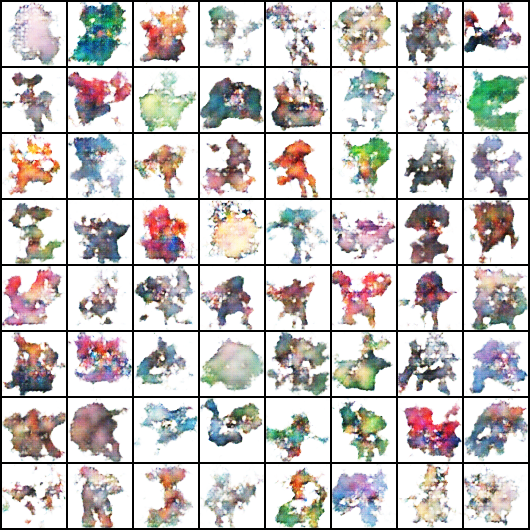

In [26]:
from IPython.display import Image
Image('./generated/generated-images-0184.png')


In [27]:
#vid_fname = 'Pokemon_gans_training.avi'

#files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
#files.sort()

#out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
#[out.write(cv2.imread(fname)) for fname in files]
#out.release()

The last two blocks involve the plotting of the "Epoch-loss" as well as "Epoch--score/accuracy" curve. 

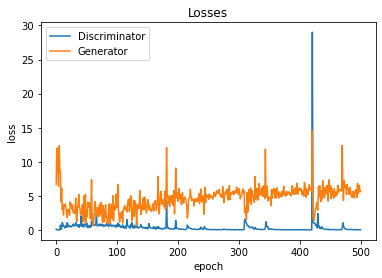

In [28]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

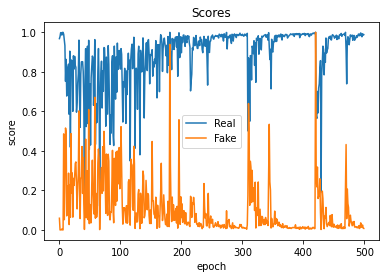

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');